In [ ]:
import torch
from torch import nn
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
import pandas as pd

In [ ]:
# setup the hyperparameters for data creation
num_classes = 4
num_features = 2
random_seed = 42

# create multiclass data
X_blob , y_blob = make_blobs(n_samples=1000,
                             n_features=num_features,
                             centers=num_classes,
                             cluster_std=1.5,
                             random_state=random_seed)

X_blob , y_blob = torch.from_numpy(X_blob).type(torch.float),torch.from_numpy(y_blob).type(torch.LongTensor)

X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
                                                                        y_blob,
                                                                        test_size=0.2,
                                                                        random_state=random_seed)

In [ ]:
df = pd.DataFrame({"x1":X_blob[:,0],
                   "x2":X_blob[:,1],
                   "y":y_blob})
df.head()

,x1,x2,y
0,-8.413396,6.935165,3
1,-5.766484,-6.431171,2
2,-6.042137,-6.766101,2
3,3.950837,0.698403,1
4,4.250492,-0.281545,1


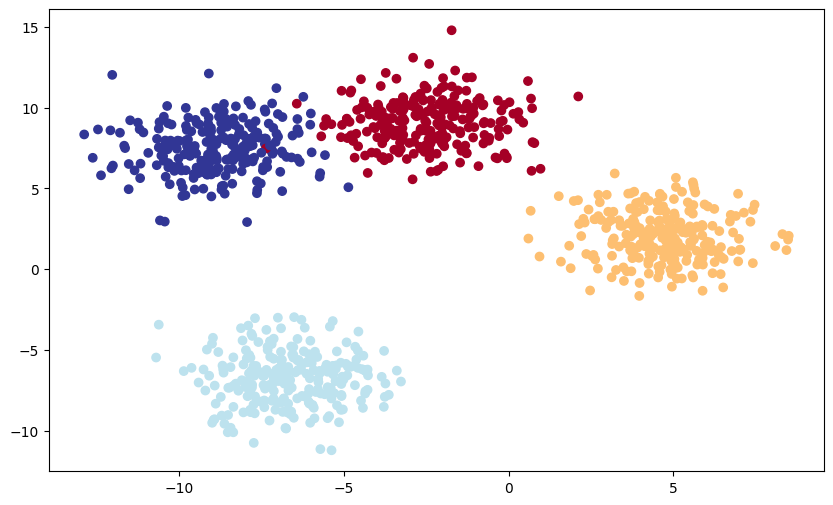

In [ ]:
plt.figure(figsize=(10,6))
plt.scatter(X_blob[:,0],X_blob[:,1],c=y_blob,cmap=plt.cm.RdYlBu);

## building a model

In [ ]:
# create device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [ ]:
# build a multiclass classification model
class BlobModel(nn.Module):
  def __init__(self,input_features,output_features,hidden_units=8):
    super().__init__()

    self.linear_layer_stack =  nn.Sequential(
        nn.Linear(in_features=input_features, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units,out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units,out_features=output_features),
    )

  def forward(self,x:torch.Tensor)->torch.Tensor:
    return self.linear_layer_stack(x)

model =  BlobModel(input_features=2,
                   output_features=4,
                   hidden_units=8
                  ).to(device)


model

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

## create a loss function and optimizer

In [ ]:
# create a loss function
loss_fn = nn.CrossEntropyLoss()

# create an optimizer function
optimizer_fn = torch.optim.SGD(params=model.parameters(),
                               lr=0.1)

def accuracy_fn(y_true,y_preds):
  correct = torch.eq(y_true,y_preds).sum().item()
  acc= (correct/len(y_preds))*100
  return acc


### getting prediction probabilities for a multiclass model

In [ ]:
model.eval()
with torch.inference_mode():
  y_logits = model(X_blob_train.to(device))
y_logits

tensor([[-1.3714e-01,  2.3774e-01, -5.7638e-01,  4.6848e-01],
        [-2.3331e+00, -4.6930e-01, -1.0263e+00, -3.9796e-01],
        [-6.3928e-01, -2.9179e-01, -8.6175e-01,  1.0348e-03],
        ...,
        [-2.2133e+00, -4.1474e-01, -9.8595e-01, -3.4866e-01],
        [-5.2868e-01, -1.9726e-01, -7.3128e-01,  5.3840e-02],
        [-2.2477e+00, -4.8121e-01, -9.9340e-01, -4.0237e-01]])

In [ ]:
y_pred_probs = torch.softmax(y_logits,dim=1)
y_pred_probs

tensor([[0.2028, 0.2950, 0.1307, 0.3716],
        [0.0553, 0.3569, 0.2045, 0.3833],
        [0.1956, 0.2768, 0.1566, 0.3710],
        ...,
        [0.0591, 0.3573, 0.2018, 0.3817],
        [0.2000, 0.2786, 0.1633, 0.3581],
        [0.0599, 0.3506, 0.2101, 0.3794]])

In [ ]:
y_preds = torch.argmax(y_pred_probs,dim=1)
y_preds[:10]

tensor([3, 3, 3, 3, 3, 1, 3, 3, 3, 3])

In [ ]:
X_blob_test.shape

torch.Size([200, 2])

## building training and loop

In [ ]:
# fit the multi-class model to the data

torch.manual_seed(42)

epochs=100

X_blob_train,y_blob_train=X_blob_train.to(device),y_blob_train.to(device)
X_blob_test,y_blob_test = X_blob_test.to(device),y_blob_test.to(device)

for epoch in range(epochs):
  # training
  model.train()

  #
  y_logits = model(X_blob_train)
  y_pred = torch.softmax(y_logits,dim=1).argmax(dim=1)


  loss = loss_fn(y_logits,y_blob_train)
  acc = accuracy_fn(y_true=y_blob_train,
                    y_preds= y_pred)

  optimizer_fn.zero_grad()
  loss.backward()
  optimizer_fn.step()

  ### testing
  model.eval()
  with torch.inference_mode():
    test_logits = model(X_blob_test)
    test_pred = torch.softmax(test_logits,dim=1).argmax(dim=1)

    test_loss = loss_fn(test_logits,y_blob_test)
    test_acc = accuracy_fn (y_true=y_blob_test,
                            y_preds=test_pred)

    if epoch%10 == 0:
      print(f"epoch {epoch}  loss:{loss:.4f}  acc:{acc:.4f}  test loss:{test_loss:.4f} test_acc :{test_acc:.4f}")

epoch 0  loss:1.6869  acc:25.2500  test loss:1.4711 test_acc :28.5000
epoch 10  loss:1.0087  acc:50.0000  test loss:0.9956 test_acc :48.5000
epoch 20  loss:0.6953  acc:70.5000  test loss:0.7032 test_acc :71.0000
epoch 30  loss:0.3833  acc:98.6250  test loss:0.3697 test_acc :99.0000
epoch 40  loss:0.1484  acc:98.8750  test loss:0.1415 test_acc :99.0000
epoch 50  loss:0.0881  acc:98.6250  test loss:0.0827 test_acc :99.0000
epoch 60  loss:0.0659  acc:99.0000  test loss:0.0609 test_acc :99.0000
epoch 70  loss:0.0548  acc:99.0000  test loss:0.0494 test_acc :99.0000
epoch 80  loss:0.0483  acc:99.0000  test loss:0.0422 test_acc :99.5000
epoch 90  loss:0.0440  acc:99.0000  test loss:0.0374 test_acc :99.5000


In [ ]:
import requests
from os import path

if path.exists("helper_functions.py"):
  print("helper function exists")

else :
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py","wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary


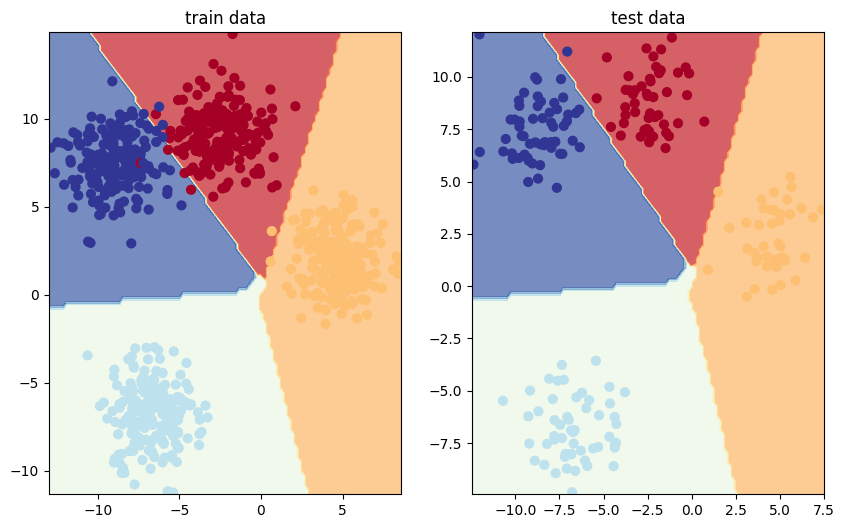

In [ ]:
# plot the decision boundry

plt.figure
plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
plt.title("train data")
plot_decision_boundary(model,X_blob_train,y_blob_train)

plt.subplot(1,2,2)
plt.title("test data")
plot_decision_boundary(model,X_blob_test,y_blob_test)